# Stefano Talamona (822452) - Assignment 2: Predicting grayscale images of letters P - Z.

---
---

In [ ]:
# Connect to Drive to get the .obj files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [169]:
# Imports
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Dropout
from tensorflow.keras import initializers
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras import metrics



---


##About the data

The dataset is composed of 22800 instances (train + test) of 28x28 grayscale images (each pixel has value in [0, 255]) of hand-written letters from P to Z.

In [83]:
x_train_og = pickle.load(open('/content/drive/MyDrive/data/x_train.obj',"rb"))
x_test_og = pickle.load(open('/content/drive/MyDrive/data/x_test.obj',"rb"))
y_train_og = pickle.load(open('/content/drive/MyDrive/data/y_train.obj',"rb"))
print("Dataset loaded")

Dataset loaded


Shape of the training set: (14000, 28, 28)
Shape of the test set: (8800, 28, 28)
Number of instances in the training set: 14000 

These are the first 10 images in the training set:


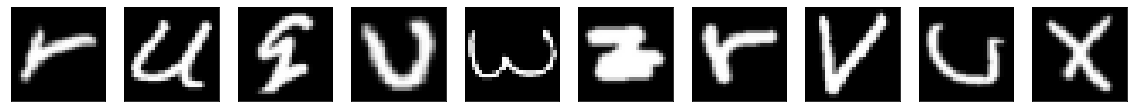

In [84]:
print("Shape of the training set:", np.shape(x_train_og))
print("Shape of the test set:", np.shape(x_test_og))
print("Number of instances in the training set:", np.shape(y_train_og)[0], "\n")

n = 10
print("These are the first", n, "images in the training set:")
plt.figure(figsize = (20, 4))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_train_og[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [85]:
print("Datatype of a single pixel value:", type(x_train_og[0, 0, 0]))
print("The values span in the range: [", np.amin(x_train_og), ",", np.amax(x_train_og), "]")
n_classes = np.amax(y_train_og) - np.amin(y_train_og) + 1
print("Number of different labels (number of different letters considered) :", n_classes)

print("\nDistribution of the samples per letter:")
min_label = np.amin(y_train_og) 
occurrences = np.bincount(y_train_og)
for i in range(min_label, min_label + n_classes):
  print(chr(i + 64), ":", occurrences[i])

Datatype of a single pixel value: <class 'numpy.uint8'>
The values span in the range: [ 0 , 255 ]
Number of different labels (number of different letters considered) : 11

Distribution of the samples per letter:
P : 1295
Q : 1265
R : 1346
S : 1329
T : 1336
U : 1297
V : 1269
W : 1327
X : 1322
Y : 1321
Z : 893




---


## Preprocessing

-The range of gray intensity pixel values is normalized in [0, 1], and the  datatype is casted from *8-bit unsigned int* to *float32*.

-The images are then reshaped to become a one-dimensional vector of pixel values.

-The labels vector is scaled from [16, 26] to [0, 10] to be encoded with the function *to_categorical()*.

-The number of samples per letter looks pretty consistent, so I'm not going to do any balancing of thtat kind.

In [101]:
# Convert to float and scale in range [0, 1]
X_train = x_train_og.astype('float32') / 255.
X_test = x_test_og.astype('float32') / 255.
# Reshape to obtain 2-dimensional data
x_train = X_train.reshape((len(x_train_og), np.prod(x_train_og.shape[1:])))
x_test = X_test.reshape((len(x_test_og), np.prod(x_test_og.shape[1:])))
# The following conversion is carried out using one-hot encoding, after 
# scaling the labels in the range [0, 11] (which is [0, n_classes])
y_train_scaled = np.copy(y_train_og)
for i in range(np.shape(y_train_og)[0]):
  y_train_scaled[i] = y_train_og[i] - min_label
y_train = np_utils.to_categorical(y_train_scaled, n_classes)

In [112]:
print("Training set size =", x_train.shape)
print("Validation set size =", x_val.shape)
print("The values now span in the range [", np.amin(x_train), ",", np.amax(x_train), "]")
print("And the datatype is now", type(x_train[0, 0]))

Training set size = (14000, 784)
Validation set size = (3500, 784)
The values now span in the range [ 0.0 , 1.0 ]
And the datatype is now <class 'numpy.float32'>




---


# 1. Supervised classification


## **Building the network**

## Structure:
The model I implemented has the following structure:

**FC@128+ReLU ---> FC@32+ReLU ---> FC@nb_classes+softmax**

I tried different number of layers and different number of units for each layer, and I came up with this specific structure since it gave the best results in terms of both accuracy and generalization capability.

## Activation functions:
Each of the two hidden layers use *ReLU* as activation function, and for the output layer I opted for the *softmax* function, which is a good choice for representing discrete probability distributions with *n* possible values, where in this case *n = n_classes = 11*. 

## Loss function:
Given the nature of the problem (and the data), the function used to calculate the loss after each step is the *categorical cross-entropy*.

## Initializer:
The initializer used is the *He Uniform initializer*, which was chosen because from the literature it seems to be the most appropriate weight initializer when the hidden layers of the model use ReLU activation function compared to the *Xavier* (Glorot) initializer ("[On weight initialization in deep neural networks](https://arxiv.org/abs/1704.08863)" Kumar, 2017).

## Optimization:
As optimizer, again based on the literature I found on the web (and since it gave satisfying results), I went for the *Adam* optimizer with standard learning rate value.

## Regularization:
About regularization, I used both *dropout* (with probability 0.1) and *L2 regularizer* (with standard regularization factor), which combined together helped me to obtain nice accuracy and loss results and also to get rid of the strong overfitting I was experiencing during the first attempts, both aspects that I noticed from the results in the following validation step and the really high loss I was getting during the training step. About the dropout probability, I tried using dropout with probability 0.5 as "starting point", and I immediately noticed that the model struggled to converge and the loss value stayed pretty high; also, during the validation step I got higher loss and lower accuracy for the training compared to the validation, meaning that I've made it harder for the network to give the right answers, and since during validation all of the units are available, the network has its full computational power, performing better than in training. Lowering that probability to 0.1 gave better results.

In [103]:
initializer = initializers.HeUniform(seed = 1234)   # He weight initializer
optimizer = optimizers.Adam(learning_rate = 0.001)  # Adam optimizer
regularizer = regularizers.l2(l2 = 0.01)            # L2 regularizer

model = Sequential()
""" FC@128+ReLU """
model.add(Dense(128, activation = "relu", kernel_initializer = initializer,
                kernel_regularizer = regularizer, bias_regularizer = regularizer,activity_regularizer = regularizer))
model.add(Dropout(rate = 0.1))
""" FC@32+ReLU """
model.add(Dense(32, activation = "relu", kernel_initializer = initializer,
                kernel_regularizer = regularizer, bias_regularizer = regularizer,activity_regularizer = regularizer))
model.add(Dropout(rate = 0.1))
""" FC@n_classes+softmax """
model.add(Dense(n_classes, activation = "softmax", kernel_initializer = initializer))

n_epochs = 75
batch_size = 128

In [104]:
# Compile
model.compile(optimizer = optimizer, loss = "categorical_crossentropy",
              metrics = ['accuracy'])
# Train
network_history = model.fit(x_train, y_train, batch_size = batch_size, epochs = n_epochs, verbose = 1)
print("Training complete!")

Epoch 1/75
110/110 [==============================] - 1s 5ms/step - loss: 3.1333 - accuracy: 0.6349
Epoch 2/75
110/110 [==============================] - 0s 4ms/step - loss: 1.5547 - accuracy: 0.8162
Epoch 3/75
110/110 [==============================] - 1s 5ms/step - loss: 1.2143 - accuracy: 0.8429
Epoch 4/75
110/110 [==============================] - 0s 5ms/step - loss: 1.0653 - accuracy: 0.8636
Epoch 5/75
110/110 [==============================] - 0s 4ms/step - loss: 0.9821 - accuracy: 0.8712
Epoch 6/75
110/110 [==============================] - 0s 4ms/step - loss: 0.9287 - accuracy: 0.8806
Epoch 7/75
110/110 [==============================] - 0s 4ms/step - loss: 0.8890 - accuracy: 0.8814
Epoch 8/75
110/110 [==============================] - 0s 4ms/step - loss: 0.8604 - accuracy: 0.8875
Epoch 9/75
110/110 [==============================] - 0s 4ms/step - loss: 0.8319 - accuracy: 0.8913
Epoch 10/75
110/110 [==============================] - 1s 5ms/step - loss: 0.8030 - accuracy: 0.8945



---


## Training results

The training results look promising, with a decent accuracy (around 93%) and loss value (not that low, but seems fine considering the results in the following validation step). These results are considered "promising" since we must remember that we are only using a fully-connected feed-forward neural network, and so we are not exploiting the true power of deep learning for image classification, which is the usage of convolutional layers. 

In [105]:
# Show results
accuracy = network_history.history["accuracy"][-1]
print("Accuracy percentage =", round(accuracy, 6) * 100)
loss = network_history.history["loss"][-1]
print("Loss =", loss)

Accuracy percentage = 93.5071
Loss = 0.47655725479125977


In the following plots it can be seen how after 75 epochs, the results of both loss and accuracy tend to converge to those previously shown values. I tried to train the model with higher number of epochs but at 75 the convergence looked fine.

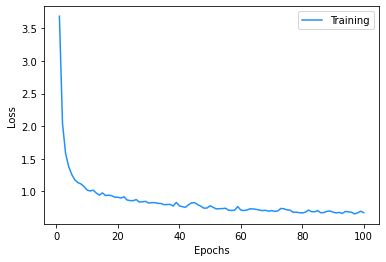

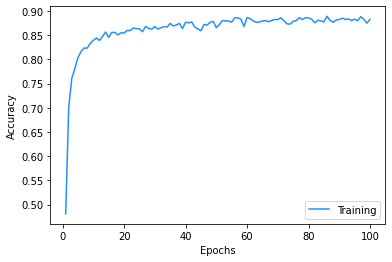

In [44]:
# Plot results
x_plot = list(range(1, n_epochs + 1))
# Loss
plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(x_plot, network_history.history['loss'], color = "dodgerblue")
plt.legend(['Training'])
# Accuracy
plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(x_plot, network_history.history['accuracy'], color = "dodgerblue")
plt.legend(['Training'], loc='lower right')
plt.show()



---


## Validation

For the validation step I decided to use (almost) every metric available in Keras. The ones that are the most meaningful in my opinion are *sensitivity* and *specificity*, since they give information about the capacity of the model to recognize *actual positives* and *actual negatives* respectively. Strong differences in the values of these two metrics may give important information about the quality of both the model and the data. For example, there may be a strong imbalance in the positive/negative samples of the dataset considered.

This is not the case, since both these values are very similar to each other, in the training as in the validation as well.

In [98]:
# Split training set into train and validation
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train)
# Set the metrics
metrics_list = [
      metrics.BinaryAccuracy(name = 'accuracy'),
      metrics.Precision(name = 'precision'),
      metrics.Recall(name = 'recall'),
      metrics.SensitivityAtSpecificity(0.9, name = 'sensitivity'),
      metrics.SpecificityAtSensitivity(0.9, name = 'specificity')
]

In [99]:
# Compile
model.compile(optimizer = optimizer, loss = "categorical_crossentropy",
              metrics = metrics_list)
# Train and validate
network_history = model.fit(x_train, y_train, batch_size = batch_size, epochs = n_epochs,
                            verbose = 2, validation_data = (x_val, y_val))

Epoch 1/75
83/83 - 2s - loss: 0.4567 - accuracy: 0.9872 - precision: 0.9491 - recall: 0.9076 - sensitivity: 0.9937 - specificity: 0.9955 - val_loss: 0.4049 - val_accuracy: 0.9897 - val_precision: 0.9581 - val_recall: 0.9277 - val_sensitivity: 0.9960 - val_specificity: 0.9978 - 2s/epoch - 23ms/step
Epoch 2/75
83/83 - 0s - loss: 0.4403 - accuracy: 0.9876 - precision: 0.9504 - recall: 0.9113 - sensitivity: 0.9948 - specificity: 0.9960 - val_loss: 0.3966 - val_accuracy: 0.9910 - val_precision: 0.9655 - val_recall: 0.9349 - val_sensitivity: 0.9954 - val_specificity: 0.9980 - 425ms/epoch - 5ms/step
Epoch 3/75
83/83 - 0s - loss: 0.4410 - accuracy: 0.9879 - precision: 0.9522 - recall: 0.9124 - sensitivity: 0.9959 - specificity: 0.9961 - val_loss: 0.4597 - val_accuracy: 0.9862 - val_precision: 0.9393 - val_recall: 0.9063 - val_sensitivity: 0.9940 - val_specificity: 0.9948 - 422ms/epoch - 5ms/step
Epoch 4/75
83/83 - 0s - loss: 0.4263 - accuracy: 0.9883 - precision: 0.9531 - recall: 0.9163 - sens

In [100]:
# Show results
print("Training:")
accuracy = network_history.history['accuracy'][-1]
precision = network_history.history['precision'][-1]
recall = network_history.history['recall'][-1]
specificity = network_history.history['specificity'][-1]
sensitivity = network_history.history['sensitivity'][-1]
loss = network_history.history['loss'][-1]
print("Accuracy =", accuracy, "(", round(accuracy, 4) * 100, "% )")
print("Precision =", precision)
print("Recall =", recall)
print("F1 score =", 2 * ((precision * recall) / (precision + recall)))
print("Specificity =", specificity)
print("sensitivity =", sensitivity)
print("Loss =", loss, "\n")

print("Validation:")
val_accuracy = network_history.history['val_accuracy'][-1]
val_precision = network_history.history['val_precision'][-1]
val_recall = network_history.history['val_recall'][-1]
val_specificity = network_history.history['val_specificity'][-1]
val_sensitivity = network_history.history['val_sensitivity'][-1]
val_loss = network_history.history['val_loss'][-1]
print("Validation accuracy =", val_accuracy, "(", round(val_accuracy, 4) * 100, "% )")
print("Validation precision =", val_precision)
print("Validation recall =", val_recall)
print("F1 score =", 2 * ((val_precision * val_recall) / (val_precision + val_recall)))
print("Specificity =", val_specificity)
print("sensitivity =", val_sensitivity)
print("Loss =", val_loss)

Training:
Accuracy = 0.9898267388343811 ( 98.98 % )
Precision = 0.9583210349082947
Recall = 0.9284762144088745
F1 score = 0.9431625862313066
Specificity = 0.9973618984222412
sensitivity = 0.9974285960197449
Loss = 0.3769623935222626 

Validation:
Validation accuracy = 0.9860259890556335 ( 98.6 % )
Validation precision = 0.9386848211288452
Validation recall = 0.9054285883903503
F1 score = 0.9217568378939679
Specificity = 0.9946285486221313
sensitivity = 0.9882857203483582
Loss = 0.45701682567596436


The high performances reached by the model made me think immediately that the model was strongly overfitting, mostly considering the kind of network we are using (which has no convolutional layers). But given the plots below, we can clearly see that there is no trace of overfitting (and neither underfitting), since the two trends of accuracy and loss for training and validation look really consistent with each other. I have to conclude that either the model I built is pretty efficient given the task and the data we are considering, or the task itself (given this particular data) is "easy".

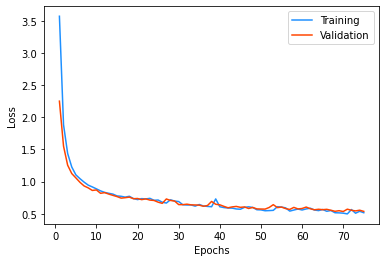

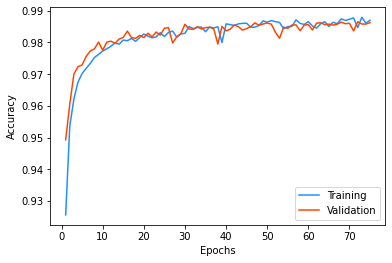

In [68]:
# Plot results
x_plot = list(range(1, n_epochs + 1))
# Loss
plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(x_plot, network_history.history['loss'], color = "dodgerblue")
plt.plot(x_plot, network_history.history['val_loss'], color = "orangered")
plt.legend(['Training', 'Validation'])
# Accuracy
plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(x_plot, network_history.history['accuracy'], color = "dodgerblue")
plt.plot(x_plot, network_history.history['val_accuracy'], color = "orangered")
plt.legend(['Training', 'Validation'], loc = 4)
plt.show()



---


## Making predictions on the provided test set

Since the results of the validation step are really promising and consistent between training and validation, I assume that unless there are strong differences in the distribution of the labels in the provided test set, the classification result should reflect the high accuracy obtained during the previous step.


Shape of the predicion vector: (8800, 11)

First 3 raw predictions:
[[3.79629171e-04 8.79753497e-05 1.12494675e-03 1.85711920e-04
  2.51050718e-04 2.24931110e-02 9.68047500e-01 7.19517004e-04
  5.86725306e-04 6.10284926e-03 2.10513936e-05]
 [5.22072241e-06 6.61998201e-05 2.54417446e-05 4.51693137e-04
  2.48242589e-03 6.56923512e-05 2.50553217e-06 2.23782317e-05
  7.99291767e-04 7.32806438e-05 9.96005833e-01]
 [4.36077418e-04 1.07551983e-03 1.63852965e-04 2.15217631e-04
  4.60180128e-03 2.45782721e-04 4.05165181e-03 1.12937894e-04
  1.19892824e-02 9.76902246e-01 2.05687844e-04]]

First 3 encoded predictions:
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

Predictions:
		 V
		 Z
		 Y
		 S
		 T
		 Y
		 U
		 P
		 S
		 V




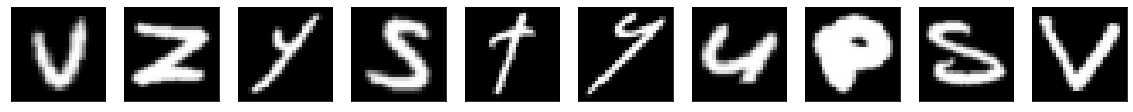

In [156]:
predictions = model.predict(x_test)
print("\nShape of the predicion vector:", predictions.shape)

print("\nFirst 3 raw predictions:")
print(predictions[: 3])

# One-Hot encode predictions
for i in range(np.shape(predictions)[0]):
  for j in range(np.shape(predictions)[1]):
    predictions[i, j] = 1 if predictions[i, j] == np.amax(predictions[i]) else 0
print("\nFirst 3 encoded predictions:")
print(predictions[: 3])

# Show first n results
n = 10 
print("\nPredictions:")
plt.figure(figsize = (20, 4))
for i in range(n):
    print("\t\t", chr(int(np.argmax(predictions[i]) + 80)))
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
print("\n")

As can be seen, the first 10 predictions correspond to the actual data.



---


## (OPTIONAL) Exporting the predictions

Since to one-hot encode the labels I scaled them in the range [0, 11], now I have to re-scale them to store the actual values of the positions of the letters in the alphabet to make it possible to estimate the results of the testing.

In [155]:
file_path = '/content/drive/MyDrive/data/Stefano_Talamona_822452_score2.txt'
f = open(file_path, "w")
for pred in predictions:
  f.write(str(np.argmax(pred) + 16) + '\n')
f.close()



---


# 2. Auto-encoder

## Building the network

I replicated almost the same structure of the auto-encoder seen during the lab activity.

In [161]:
# with encoding_dim = 32 : compression of factor 24.5 with input size 784 
encoding_dim = 64  # with encoding_dim = 64 : compression of factor 12.25  
input_img = Input(shape = (784, ))   
encoded = Dense(encoding_dim, activation = 'relu')(input_img)
decoded = Dense(784, activation = 'sigmoid')(encoded)
autoencoder = Model(input_img, decoded)

In [162]:
autoencoder.compile(optimizer = "adam", loss = 'binary_crossentropy', metrics = ["mse"])
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_33 (Dense)            (None, 64)                50240     
                                                                 
 dense_34 (Dense)            (None, 784)               50960     
                                                                 
Total params: 101,200
Trainable params: 101,200
Non-trainable params: 0
_________________________________________________________________


In [163]:
# Here, input data and target data are exactly the same, since we
# want to find an encoding that can represent our training
# data in the most precise (yet compressed) way;
autoencoder.fit(x_train, x_train,
                epochs = 50, # limited to 50 since it seems to converge enough after that number of epochs
                batch_size = 512,
                shuffle = True,
                validation_data = (x_val, x_val))

Epoch 1/50
28/28 [==============================] - 1s 25ms/step - loss: 0.5216 - mse: 0.1409 - val_loss: 0.3781 - val_mse: 0.0873
Epoch 2/50
28/28 [==============================] - 1s 21ms/step - loss: 0.3554 - mse: 0.0819 - val_loss: 0.3351 - val_mse: 0.0754
Epoch 3/50
28/28 [==============================] - 1s 21ms/step - loss: 0.3177 - mse: 0.0691 - val_loss: 0.2996 - val_mse: 0.0626
Epoch 4/50
28/28 [==============================] - 1s 21ms/step - loss: 0.2844 - mse: 0.0571 - val_loss: 0.2706 - val_mse: 0.0524
Epoch 5/50
28/28 [==============================] - 1s 22ms/step - loss: 0.2595 - mse: 0.0486 - val_loss: 0.2502 - val_mse: 0.0454
Epoch 6/50
28/28 [==============================] - 1s 21ms/step - loss: 0.2415 - mse: 0.0425 - val_loss: 0.2344 - val_mse: 0.0402
Epoch 7/50
28/28 [==============================] - 1s 21ms/step - loss: 0.2273 - mse: 0.0378 - val_loss: 0.2216 - val_mse: 0.0359
Epoch 8/50
28/28 [==============================] - 1s 23ms/step - loss: 0.2156 - m



---


## Inspecting the visual results 

The results in terms of visual representation look similar enough with respect to the original data. I tried using *Mean Square Error* as loss function and *Linear* activation in the *decoder* layer, but the results looked less similar to the original data, with some sort of strong artifacts around the letters (I mean around the white regions of the images). It can be noticed how the model performs well on simple shapes, but struggles a bit on small lines/corners.

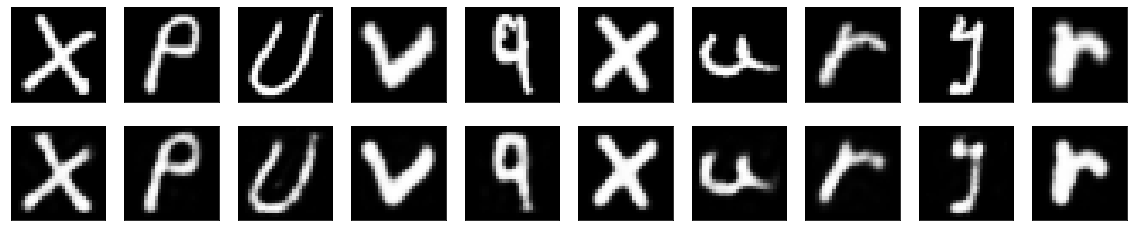

In [164]:
decoded_imgs = autoencoder.predict(x_val)
n = 10 
plt.figure(figsize = (20, 4))
for i in range(n):
    # original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_val[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()



---


# 3. (OPTIONAL) Using the encoded representation generated by the auto-encoder to solve the problem of supervised classification

For this step, I am just going to feed the encoded data to the same exact model built in the previous steps, and then investigate the results. To do that I am defining a new model, called *optional_model*, which is a *Sequential()* object just like the one used in the training and validation steps, but with the addition of an input layer and an encoding layer to encode the data before feeding it to the network.

In [165]:
# Build the desired model which will encode the data and pass it as
# the input for the model that will perform the actual classification
optional_model = Sequential()
optional_model.add(Input(shape = (784, ))) 
optional_model.add(Dense(encoding_dim, activation = 'relu'))
optional_model.add(Dense(128, activation = "relu", kernel_initializer = initializer,
                  kernel_regularizer = regularizer, bias_regularizer = regularizer,activity_regularizer = regularizer))
optional_model.add(Dropout(rate = 0.1))
optional_model.add(Dense(32, activation = "relu", kernel_initializer = initializer,
                 kernel_regularizer = regularizer, bias_regularizer = regularizer,activity_regularizer = regularizer))
optional_model.add(Dropout(rate = 0.1))
optional_model.add(Dense(n_classes, activation = "softmax", kernel_initializer = initializer))

In [166]:
# Compile
optional_model.compile(optimizer = optimizer, loss = "categorical_crossentropy",
              metrics = metrics_list)
# Train and validate
network_history = optional_model.fit(x_train, y_train, batch_size = batch_size, epochs = n_epochs,
                            verbose = 2, validation_data = (x_val, y_val))

Epoch 1/75
110/110 - 3s - loss: 1.8197 - accuracy: 0.9591 - precision: 0.9174 - recall: 0.6042 - sensitivity: 0.8919 - specificity: 0.8997 - val_loss: 0.8998 - val_accuracy: 0.9731 - val_precision: 0.9347 - val_recall: 0.7569 - val_sensitivity: 0.9677 - val_specificity: 0.9744 - 3s/epoch - 23ms/step
Epoch 2/75
110/110 - 0s - loss: 0.8099 - accuracy: 0.9766 - precision: 0.9371 - recall: 0.7958 - sensitivity: 0.9721 - specificity: 0.9830 - val_loss: 0.6697 - val_accuracy: 0.9834 - val_precision: 0.9592 - val_recall: 0.8540 - val_sensitivity: 0.9837 - val_specificity: 0.9925 - 446ms/epoch - 4ms/step
Epoch 3/75
110/110 - 0s - loss: 0.6691 - accuracy: 0.9818 - precision: 0.9497 - recall: 0.8450 - sensitivity: 0.9819 - specificity: 0.9912 - val_loss: 0.5889 - val_accuracy: 0.9853 - val_precision: 0.9587 - val_recall: 0.8760 - val_sensitivity: 0.9880 - val_specificity: 0.9946 - 496ms/epoch - 5ms/step
Epoch 4/75
110/110 - 0s - loss: 0.5930 - accuracy: 0.9850 - precision: 0.9565 - recall: 0.874

##Results

In [167]:
# Show results
print("Training:")
accuracy = network_history.history['accuracy'][-1]
precision = network_history.history['precision'][-1]
recall = network_history.history['recall'][-1]
specificity = network_history.history['specificity'][-1]
sensitivity = network_history.history['sensitivity'][-1]
loss = network_history.history['loss'][-1]
print("Accuracy =", accuracy, "(", round(accuracy, 4) * 100, "% )")
print("Precision =", precision)
print("Recall =", recall)
print("F1 score =", 2 * ((precision * recall) / (precision + recall)))
print("Specificity =", specificity)
print("sensitivity =", sensitivity)
print("Loss =", loss, "\n")

print("Validation:")
val_accuracy = network_history.history['val_accuracy'][-1]
val_precision = network_history.history['val_precision'][-1]
val_recall = network_history.history['val_recall'][-1]
val_specificity = network_history.history['val_specificity'][-1]
val_sensitivity = network_history.history['val_sensitivity'][-1]
val_loss = network_history.history['val_loss'][-1]
print("Validation accuracy =", val_accuracy, "(", round(val_accuracy, 4) * 100, "% )")
print("Validation precision =", val_precision)
print("Validation recall =", val_recall)
print("F1 score =", 2 * ((val_precision * val_recall) / (val_precision + val_recall)))
print("Specificity =", val_specificity)
print("sensitivity =", val_sensitivity)
print("Loss =", val_loss)

Training:
Accuracy = 0.997909665107727 ( 99.79 % )
Precision = 0.9924395084381104
Recall = 0.984499990940094
F1 score = 0.9884538068799972
Specificity = 0.999914288520813
sensitivity = 0.9998571276664734
Loss = 0.14848263561725616 

Validation:
Validation accuracy = 0.9981299638748169 ( 99.81 % )
Validation precision = 0.9930955171585083
Validation recall = 0.9862856864929199
F1 score = 0.9896788876107846
Specificity = 0.999914288520813
sensitivity = 1.0
Loss = 0.13685327768325806


As can be seen, the results in terms of the metrics considered are even better with the encoded data. Especially, the loss value is much smaller.

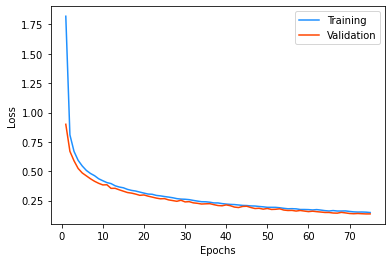

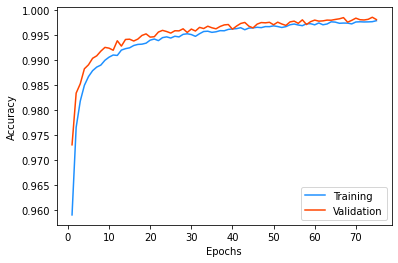

In [168]:
# Plot results
x_plot = list(range(1, n_epochs + 1))
# Loss
plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(x_plot, network_history.history['loss'], color = "dodgerblue")
plt.plot(x_plot, network_history.history['val_loss'], color = "orangered")
plt.legend(['Training', 'Validation'])
# Accuracy
plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(x_plot, network_history.history['accuracy'], color = "dodgerblue")
plt.plot(x_plot, network_history.history['val_accuracy'], color = "orangered")
plt.legend(['Training', 'Validation'], loc = 4)
plt.show()

The trends look consistent, and there is no trace of strong overfitting, even if (slightly) higher accuracy and (again, slightly) lower loss in the validation with respect to the training, seem to indicate that the model is in fact overfitting (at least a little bit).



---

